In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
kaggle/input/tabular-playground-series-aug-2022/test.csv
kaggle/input/tabular-playground-series-aug-2022/train.csv


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

2024-10-05 16:20:49.045996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 16:20:49.050211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 16:20:49.552577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 16:20:50.577948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 16:20:57.705668: W tensorflow/compiler/tf2

In [3]:
import absl.logging
import warnings
import logging

from tabtransformertf.models.tabtransformer import TabTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep

logging.captureWarnings(True)
warnings.filterwarnings('ignore')
absl.logging.set_verbosity(absl.logging.ERROR)

In [4]:
train_data = pd.read_csv('kaggle/input/tabular-playground-series-aug-2022/train.csv').set_index('id')
test_data = pd.read_csv('kaggle/input/tabular-playground-series-aug-2022/test.csv').set_index('id')

In [5]:
train_data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


#### Feature Engineering

In [6]:
measurement_columns = [f'measurement_{i}' for i in range(18)]

In [7]:
from tqdm import tqdm

def convert_area(area):
    if area < 40:
        s = 'small'
    elif area < 60:
        s = 'medium'
    else:
        s = 'large'
    
    return s


train_data['area'] = train_data['attribute_2'] * train_data['attribute_3']
test_data['area'] = test_data['attribute_2'] * test_data['attribute_3']
train_data['area_label'] = train_data['area'].apply(lambda x: convert_area(x))
test_data['area_label'] = test_data['area'].apply(lambda x: convert_area(x))

train_data['avg_measurement'] = train_data[measurement_columns].mean(axis=1)
test_data['avg_measurement'] = test_data[measurement_columns].mean(axis=1)

train_data['std_measurement'] = train_data[measurement_columns].std(axis=1)
test_data['std_measurement'] = test_data[measurement_columns].std(axis=1)

#### Preprocessing

In [8]:
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['failure'])
train_data.shape, val_data.shape, test_data.shape

((21256, 29), (5314, 29), (20775, 28))

In [9]:
train_data.columns

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'failure', 'area',
       'area_label', 'avg_measurement', 'std_measurement'],
      dtype='object')

In [10]:
# Column information
NUMERIC_FEATURES = [ 'loading', 'area','avg_measurement','std_measurement', 'attribute_2', 'attribute_3']
NUMERIC_FEATURES += measurement_columns

CATEGORICAL_FEATURES = ['attribute_0', 'attribute_1', 'area_label']

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL = 'failure'

#### Numeric Cleaning

In [11]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

numeric_pipe = Pipeline([
    ('impute', imputer),
    ('scale', scaler),
])

numeric_pipe.fit(train_data[NUMERIC_FEATURES])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [12]:
train_data[NUMERIC_FEATURES] = numeric_pipe.transform(train_data[NUMERIC_FEATURES])
val_data[NUMERIC_FEATURES] = numeric_pipe.transform(val_data[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = numeric_pipe.transform(test_data[NUMERIC_FEATURES])

#### Discretising Measurements

In [13]:
from tqdm import tqdm
for f in tqdm(measurement_columns):
    disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    train_data[f'{f}_bined'] = disc.fit_transform(train_data[f].values.reshape(-1, 1)).astype('str')
    val_data[f'{f}_bined'] = disc.transform(val_data[f].values.reshape(-1, 1)).astype('str')
    test_data[f'{f}_bined'] = disc.transform(test_data[f].values.reshape(-1, 1)).astype('str')

100%|██████████| 18/18 [00:00<00:00, 72.64it/s]


#### Column Dtypes

In [14]:
# Column information
NUMERIC_FEATURES = [ 'loading', 'area','avg_measurement','std_measurement', 'attribute_2', 'attribute_3']

CATEGORICAL_FEATURES = [
    'attribute_0', 'attribute_1', 'area_label', 'measurement_0_bined', 
    'measurement_1_bined', 'measurement_2_bined', 'measurement_3_bined', 
    'measurement_4_bined', 'measurement_5_bined', 'measurement_6_bined',
    'measurement_7_bined', 'measurement_8_bined', 'measurement_9_bined', 
    'measurement_10_bined', 'measurement_11_bined', 'measurement_12_bined',
    'measurement_13_bined', 'measurement_14_bined', 'measurement_15_bined',
    'measurement_16_bined', 'measurement_17_bined'
]
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

In [15]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

#### Categroy Lookup Layers

In [16]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)
category_prep_layers

  0%|          | 0/21 [00:00<?, ?it/s]2024-10-05 16:21:23.347483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-05 16:21:25.177505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-05 16:21:25.177914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-05 16:21:25.179948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-05 16:21:25.180200: I 

{'attribute_0': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93eac4a170>,
 'attribute_1': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93eb7f2980>,
 'area_label': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6c4c0>,
 'measurement_0_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6e020>,
 'measurement_1_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6cdc0>,
 'measurement_2_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6ddb0>,
 'measurement_3_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6e620>,
 'measurement_4_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6ebc0>,
 'measurement_5_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6f160>,
 'measurement_6_bined': <keras.src.layers.preprocessing.string_lookup.StringLookup at 0x7f93e8a6f7

#### To TF Dataset

In [17]:
def df_to_dataset(
    dataframe: pd.DataFrame,
    target: str = None,
    shuffle: bool = True,
    batch_size: int = 512,
):
    df = dataframe.copy()
    if target:
        labels = df.pop(target)
        dataset = {}
        for key, value in df.items():
            dataset[key] = value.to_numpy()[:, tf.newaxis]

        dataset = tf.data.Dataset.from_tensor_slices((dict(dataset), labels))
    else:
        dataset = {}
        for key, value in df.items():
            dataset[key] = value.to_numpy()[:, tf.newaxis]

        dataset = tf.data.Dataset.from_tensor_slices(dict(dataset))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(batch_size)
    return dataset

In [18]:
train_dataset = df_to_dataset(train_data[FEATURES + [LABEL]], LABEL, batch_size=3072)
val_dataset = df_to_dataset(val_data[FEATURES + [LABEL]], LABEL, shuffle=False, batch_size=3072)
test_dataset = df_to_dataset(test_data[FEATURES], None, shuffle=False, batch_size=3072)

#### TabTransformer Model

In [19]:
for f in tqdm(measurement_columns):
    disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    train_data[f'{f}_bined'] = disc.fit_transform(train_data[f].values.reshape(-1, 1)).astype('str')
    val_data[f'{f}_bined'] = disc.transform(val_data[f].values.reshape(-1, 1)).astype('str')
    
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

tabtransformer = TabTransformer(
        numerical_features = NUMERIC_FEATURES,
        categorical_features = CATEGORICAL_FEATURES,
        categorical_lookup=category_prep_layers,
        numerical_discretisers=None, # simply passing the numeric features
        embedding_dim=32,
        out_dim=1,
        out_activation='sigmoid',
        depth=6,
        heads=5,
        attn_dropout=0.087687,
        ff_dropout=0.429539,
        mlp_hidden_factors=[1, 1],
        use_column_embedding=False,
    )

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

tabtransformer.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics= [tf.keras.metrics.AUC(name="AUC", curve='ROC')],
)

early = EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

history = tabtransformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list,
    verbose=1,
)

100%|██████████| 21/21 [00:00<00:00, 259.45it/s]


Epoch 1/1000


2024-10-05 16:21:33.898776: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-05 16:21:34.134203: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7/7 [==============================] - 13s 356ms/step - loss: 0.8735 - AUC: 0.5023 - val_loss: 0.5452 - val_AUC: 0.5421
Epoch 2/1000
7/7 [==============================] - 2s 208ms/step - loss: 0.7243 - AUC: 0.5089 - val_loss: 0.5556 - val_AUC: 0.5188
Epoch 3/1000
7/7 [==============================] - 2s 211ms/step - loss: 0.6613 - AUC: 0.5055 - val_loss: 0.5504 - val_AUC: 0.5573
Epoch 4/1000
7/7 [==============================] - 2s 217ms/step - loss: 0.6216 - AUC: 0.5175 - val_loss: 0.5288 - val_AUC: 0.5422
Epoch 5/1000
7/7 [==============================] - 2s 221ms/step - loss: 0.6130 - AUC: 0.5067 - val_loss: 0.5233 - val_AUC: 0.5605
Epoch 6/1000
7/7 [==============================] - 4s 672ms/step - loss: 0.5960 - AUC: 0.5206 - val_loss: 0.5364 - val_AUC: 0.5486
Epoch 7/1000
7/7 [==============================] - 2s 234ms/step - loss: 0.5864 - AUC: 0.5211 - val_loss: 0.5284 - val_AUC: 0.5531
Epoch 8/1000
7/7 [==============================] - 2s 227ms/step - loss: 0.5804 - AUC: 

In [20]:
val_preds = tabtransformer.predict(val_dataset)

print(f"PR AUC: {average_precision_score(val_data[LABEL], val_preds.ravel())}")
print(f"ROC AUC: {roc_auc_score(val_data[LABEL], val_preds.ravel())}")

2/2 [==============================] - 1s 60ms/step
PR AUC: 0.25905653166647014
ROC AUC: 0.5761721856545796


#### Test Submission

In [21]:
test_preds = tabtransformer.predict(test_dataset)

submission = pd.DataFrame({
    "id": test_data.index,
    "failure": test_preds.ravel()
})

submission.to_csv("submission.csv", index=False)

7/7 [==============================] - 1s 65ms/step


In [22]:
submission.head()

,id,failure
0,26570,0.221068
1,26571,0.133359
2,26572,0.215361
3,26573,0.220235
4,26574,0.269983


7/7 [==============================] - 1s 67ms/step


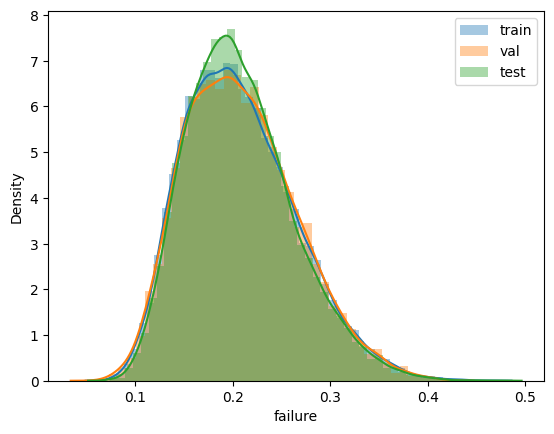

In [23]:
train_preds = tabtransformer.predict(train_dataset)

sns.distplot(train_preds, label='train')
sns.distplot(val_preds, label='val')
sns.distplot(submission['failure'], label='test')
plt.legend()